In [1]:
"""Offset and UPDRS correlaiton."""
%load_ext autoreload
%autoreload 2
from analysis_settings import *
from plot_settings import *
from scipy.stats import wilcoxon
import numpy as np
import pingouin as pg
from scipy.stats import bootstrap
from scripts.utils_plot import _get_cohen_stats, _save_fig, convert_pvalue_to_asterisks, equalize_x_and_y, cohen_d

In [2]:
ch_choice = 'ch_dist_sweet'
dataframes = get_dfs(ch_choice)
errorbar = ('ci', CI)
estimator = 'effect_size'  # median

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

In [3]:
def _cohens_anno(effect_size):
    return f"{effect_size:.2f}"


# def _wilcox_anno(p_value, format='long'):
#     if format == 'long':
#         if p_value >= 0.05:
#             wilcoxon_str = rf'$p={p_value:.3f}$'
#         elif p_value >= 0.01:
#             wilcoxon_str = r'$\bf p \leq 0.05$'  # make bold
#         elif p_value >= 0.001:
#             wilcoxon_str = r'$\bf p \leq 0.01$'  # make bold
#         elif p_value >= 0.0001:
#             wilcoxon_str = r'$\bf p \leq 0.001$'  # make bold
#         else:
#             wilcoxon_str = rf'$\bf p={p_value:1.0e}$'

#     elif format == 'short':
#         # if p_value <= 0.0001:
#         #     wilcoxon_str =  "****"
#         if p_value <= 0.001:
#             wilcoxon_str =  "***"
#         elif p_value <= 0.01:
#             wilcoxon_str =  "**"
#         elif p_value <= 0.05:
#             wilcoxon_str =  "*"
#         else:
#             wilcoxon_str =  ""
#     return wilcoxon_str


def band_labels(y_col):
    for band in BANDS:
        if band in y_col:
            band = cfg.BAND_NAMES[band]
            return band.replace(' ', '\n')
    # Aperiodic names
    band = cfg.PLOT_LABELS[y_col]
    return band.replace(' ', '\n')
    # try:
    #     band = '_'.join(y_col.replace('_fm', '').split('_')[:-3])
    #     band = cfg.BAND_NAMES[band]
    # except KeyError:


def _stats_annotations(ax, effect_sizes, p_values):
    xticks = ax.get_xticks()
    _, ymax = ax.get_ylim()
    y_wil = ymax * 1.1
    y_coh = y_wil + .1
    # y_coh = ymax * 1.1
    # y_wil = y_coh + .1
    xmin = ax.get_xlim()[0]
    for i in range(len(effect_sizes)):
        effect_size = effect_sizes[i]
        p_value = p_values[i]
        xtick = xticks[i]
        anno_coh = _cohens_anno(effect_size)
        # anno_wil = _wilcox_anno(p_value, format='short')
        anno_wil = convert_pvalue_to_asterisks(p_value)
        ax.text(xtick, y_wil-.035, anno_wil, ha='center',
                fontsize=FONTSIZE_ASTERISK, color='grey')
        ax.text(xtick, y_coh, anno_coh, ha='center')
    ax.text(xmin, y_wil, "Wilcoxon", ha='right', color='grey')
    ax.text(xmin, y_coh, "Cohen's d", ha='right')


def _get_stats(df_wil, df_coh, ycols, multiple_comparison=True):
    df_wil_all = df_wil[df_wil.project == 'all']
    effect_sizes = []
    p_values = []
    for y in ycols:
        effect_size, n_cohen = _get_cohen_stats(df_coh, 'cond', y=y)
        effect_sizes.append(effect_size)

        xy_diff = df_wil_all[y].dropna().to_numpy()
        pvalue = wilcoxon(xy_diff).pvalue

        if multiple_comparison:
            pvalue /= len(ycols)
        p_values.append(pvalue)
    return effect_sizes, p_values

In [4]:
figsize = (2, 1)
show_units = False  # too little space, can be mentioned in legend
multiple_comparison = True  # divide pvalue by number of bands

projects = cfg.PROJECT_ORDER_SLIM
palette = [cfg.COLOR_DIC[proj] for proj in projects]

# Set linewidths proportional to sample sizes
# sample_sizes = [(df_norm_wil.project == proj).sum() for proj in projects]
# factor = min(sample_sizes) / .25  # make sure no lines thinner than 0.25
# line_widths = {proj: 1/factor * sample_sizes[i]
#                for i, proj in enumerate(projects)}
line_widths = {proj: .25 for proj in projects}
line_widths['all'] = LINEWIDTH_PLOT

## Statistics clarify:
- use 95% confidence interval or standard error?
    - CI is non-parametric and more realistic, therefore better
- plot mean or median in pointplot?
    - mean corresponds better to effect size
    - median is more outlier robust

In [5]:
def band_barplot(df, kind, ycols, save_dir='Figure1', figsize=(.9, 0.9),
                 projects=cfg.PROJECT_ORDER_SLIM, n_boot=None,
                 xticklabels=None):
    names = []
    values = []
    errors = []
    significances = []
    project_list = []
    for proj in projects:
        for ycol in ycols:
            names.append(ycol)
            project_list.append(proj)
            df_proj = df[(df.project == proj)]

            # equalize x and y to enhance statistics (paired=True)
            df_proj, n = equalize_x_and_y(df_proj, 'cond', ycol)
            off_arr = df_proj[df_proj.cond == 'off'][ycol].values
            on_arr = df_proj[df_proj.cond == 'on'][ycol].values
            if estimator == 'effect_size':
                value = cohen_d(off_arr, on_arr)
                if np.all(off_arr == 0) or np.all(on_arr == 0):
                    # effect size unreasonable if all values are zero
                    value = np.nan
                data = (off_arr, on_arr)
                func = cohen_d
            else:
                if estimator == 'mean':
                    func = np.mean
                elif estimator == 'median':
                    func = np.median
                else:
                    raise ValueError('Unknown estimator')
                value = func(off_arr - on_arr)
                data = (off_arr - on_arr,)
            if proj == 'all':
                print(f'{estimator} {ycol}: {value:.2f}')
            values.append(value)
            if n_boot is None:
                assert estimator == 'effect_size', 'Only effect size supports parametric'
                # parametric (fast but more assumptions)
                ci = pg.compute_esci(value, n, paired=True)
            else:
                # nonparametric (slow but more correct)
                result = bootstrap(data, func, n_resamples=n_boot, paired=True,
                                random_state=1)
                ci = result.confidence_interval
                # if distribution is degenerate (many 0 values), apply parametric
                if np.any(np.isnan(result.bootstrap_distribution)):
                    ci = pg.compute_esci(value, n, paired=True)

            # CIs
            ci_lower, ci_upper = ci
            error = [[abs(value - ci_lower)], [abs(ci_upper - value)]]
            errors.append(error)
            # make sure that np.nan values are not significant
            if value is np.nan:
                significant = False
            elif ci_lower < 0 and ci_upper < 0 or ci_lower > 0 and ci_upper > 0:
                significant = True
            else:
                significant = False
            significances.append(significant)

    df_plot = pd.DataFrame({'project': project_list, 'band': names,
                            'value': values, 'ci': errors,
                            'significant': significances})
    capsize = 1 if len(projects) > 1 else 0
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    # fig, ax = plt.subplots(1, 1, figsize=(.6, 0.6))

    ax.axhline(0, color="k", lw=LINEWIDTH_AXES, ls='--')
    for i, proj in enumerate(projects):
        df_proj = df_plot[df_plot.project == proj]
        # Plot CIs
        yerr = [item for sublist in df_proj.ci.values for item in sublist]
        yerr = np.array(yerr).reshape(len(ycols), 2).T
        values = df_proj.value.values

        xticks = np.arange(len(ycols))# + 0.03 * i
        color = cfg.COLOR_DIC[proj] if len(projects) > 1 else cfg.COLOR_DIC[kind]
        sns.barplot(x=xticks, y=values, yerr=yerr, ax=ax, capsize=capsize,
                    color=color, errwidth=line_widths[proj], errcolor='k')
        # ax.annotate(f'{values[0]:.2f}', xy=(xticks[0], .12), ha='center')
        # ax.annotate(f'{values[1]:.2f}', xy=(xticks[1], .12), ha='center')
        # ax.bar_label(ax.containers[1], fmt='%.2f',
        #              padding=-20)
        _, ymax = ax.get_ylim()
        for j, sig in enumerate(significances):
            if sig:
                ax.text(xticks[j], ymax*.95, '*', ha='center',
                        fontsize=FONTSIZE_ASTERISK, color='k')

    if xticklabels is None:
        # labels = [cfg.PLOT_LABELS_SHORT[y_col] for y_col in ycols]
        labels = [cfg.PLOT_LABELS[y_col] for y_col in ycols]
    else:
        labels = xticklabels
    ax.set_xticks(xticks, labels=labels)
    ax.tick_params(axis='x', length=0)
    ylabel = 'Cohen\'s d'f' {cfg.COND_DICT['off']}-{cfg.COND_DICT['on']}'
    ax.set_ylabel(ylabel)
    # ax.set_title()
    # ax.set_yticks([])
    ax.set_xlabel(None)
    # sns.despine(bottom=True, left=True)
    sns.despine(bottom=True)

    # df_cohen = df[df.cond.isin(['on', 'off']) & df.project.isin(['all'])]
    # effect_sizes, p_values = _get_stats(df_wilcoxon, df_cohen, ycols,
    #                                     multiple_comparison=multiple_comparison)
    # _stats_annotations(ax, effect_sizes, p_values)
    plt.tight_layout()
    # _save_fig(fig, f'{save_dir}/broadband_OFFON_{kind}', SAVE_DIR,
    #           transparent=False, facecolor='white',
    #           close=False, bbox_inches=None)
    plt.show()


# Aperiodic parameters

In [11]:
n_perm = 10000
# n_perm = None

In [14]:
df_abs = dataframes['df_abs']
df_per = dataframes['df_per']

effect_size fm_exponent: -0.15
effect_size fm_offset_log: -0.11
effect_size full_fm_band_aperiodic_log: 0.03


/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_89866/3062596845.py:81: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x=xticks, y=values, yerr=yerr, ax=ax, capsize=capsize,
/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_89866/3062596845.py:81: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  sns.barplot(x=xticks, y=values, yerr=yerr, ax=ax, capsize=capsize,


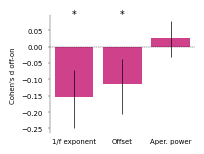

In [15]:
kind = 'periodicAP'
ycols = ['fm_exponent', 'fm_offset_log', 'full_fm_band_aperiodic_log']
band_barplot(df_per, kind, ycols, save_dir=f'{KIND_DIR[kind]}/{ch_choice}/',
             projects=['all'], n_boot=n_perm, figsize=(2, 1.5),
             xticklabels=['1/f exponent', 'Offset', 'Aper. power'])
# break

# Broadband power

effect_size psd_sum_5to95: -0.05


/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_89866/3062596845.py:81: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x=xticks, y=values, yerr=yerr, ax=ax, capsize=capsize,
/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_89866/3062596845.py:81: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  sns.barplot(x=xticks, y=values, yerr=yerr, ax=ax, capsize=capsize,


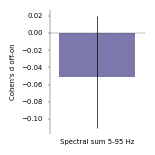

In [16]:
kind = 'absolute'
ycols = ['psd_sum_5to95']
band_barplot(df_abs, kind, ycols, save_dir=f'{KIND_DIR[kind]}/{ch_choice}/',
             projects=['all'], n_boot=n_perm, figsize=(1.5, 1.5), xticklabels=['Spectral sum 5-95 Hz'])
# break

In [16]:
1/0

ZeroDivisionError: division by zero

In [73]:

def band_barplot_severity(df, kind, ycols, save_dir='Figure1',
                          cond='off', n_boot=None):
    ylabel = 'Pwr. Severe-Mild'
    names = []
    values = []
    errors = []
    significances = []
    df_cond = df[(df.cond == cond)]
    for ycol in ycols:
        names.append(ycol)

        # equalize x and y to enhance statistics (paired=True)
        # df_proj, n = equalize_x_and_y(df_proj, 'cond', ycol)
        paired = False
        lateralized_updrs = False
        sampling = 'hemispheres' if lateralized_updrs else 'patients'
        rename = {'mild_half': f'Mild {sampling}',
                'severe_half': f'Severe {sampling}'}
        hue_order = [f'Severe {sampling}', f'Mild {sampling}']
        updrs = 'UPDRS_III'
        hue = f'{updrs}_severity_median'
        df_cond[hue] = df_cond[hue].astype('category')
        df_cond[hue] = df_cond[hue].cat.rename_categories(rename)
        df_cond[hue] = df_cond[hue].cat.remove_unused_categories()
        df_cond = df_cond[df_cond[hue].isin(hue_order)]
        if not lateralized_updrs:
            # average hemispheres
            group = df_cond.groupby(['subject'])
            # df_cond = df_cond.dropna(subset=[x] + y_vals)
            # df_cond[x] = group[x].transform("mean")
            df_cond[ycol] = group[ycol].transform("mean")
            df_cond = df_cond.drop_duplicates(subset=["subject"])
            cluster_str = 'across_mean'
        else:
            cluster_str = 'across'
        cluster_conds = df_cond[hue].unique()
        assert len(cluster_conds) == 2

        df1 = df_cond[df_cond[hue] == cluster_conds[0]]
        df2 = df_cond[df_cond[hue] == cluster_conds[1]]
        arr1 = df1[ycol].values
        arr2 = df2[ycol].values
        nx = len(arr1)
        ny = len(arr2)

        if estimator == 'effect_size':
            value = cohen_d(arr1, arr2)
            if np.all(arr1 == 0) or np.all(arr2 == 0):
                # effect size unreasonable if all values are zero
                value = np.nan
            data = (arr1, arr2)
            func = cohen_d
        else:
            if estimator == 'mean':
                func = np.mean
            elif estimator == 'median':
                func = np.median
            else:
                raise ValueError('Unknown estimator')
            value = func(arr1 - arr2)
            data = (arr1 - arr2,)
        print(f'{estimator} {band}: {value:.2f}')
        values.append(value)
        if n_boot is None:
            assert estimator == 'effect_size', 'Only effect size supports parametric'
            # parametric (fast but more assumptions)
            ci = pg.compute_esci(value, nx, ny, paired=paired)
        else:
            # nonparametric (slow but more correct)
            result = bootstrap(data, func, n_resamples=n_boot, paired=paired,
                            random_state=1)
            ci = result.confidence_interval
            # if distribution is degenerate (many 0 values), apply parametric
            if np.any(np.isnan(result.bootstrap_distribution)):
                ci = pg.compute_esci(value, n, paired=paired)

        # CIs
        ci_lower, ci_upper = ci
        error = [[abs(value - ci_lower)], [abs(ci_upper - value)]]
        errors.append(error)
        # make sure that np.nan values are not significant
        if value is np.nan:
            significant = False
        elif ci_lower < 0 and ci_upper < 0 or ci_lower > 0 and ci_upper > 0:
            significant = True
        else:
            significant = False
        significances.append(significant)

    df_plot = pd.DataFrame({'band': names,
                            'value': values, 'ci': errors,
                            'significant': significances})
    capsize = 1 if len(projects) > 1 else 0
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 0.5))

    ax.axhline(0, color="k", lw=LINEWIDTH_AXES, ls='--')
    # Plot CIs
    yerr = [item for sublist in df_plot.ci.values for item in sublist]
    # yerr = df_plot.ci.values
    yerr = np.array(yerr).reshape(len(ycols), 2).T
    values = df_plot.value.values

    xticks = np.arange(len(ycols))
    color = cfg.COLOR_DIC[kind]
    sns.barplot(x=xticks, y=values, yerr=yerr, ax=ax, capsize=capsize,
                color=color, errcolor='k')

    labels = [cfg.PLOT_LABELS[y_col] for y_col in ycols]
    ax.set_xticks(np.arange(len(ycols)), labels=labels)
    ax.tick_params(axis='x', length=0)

    ylabel = 'Severe vs Mild\n[Cohen\'s d]'
    ylabel = 'Cohen\'s d'
    ax.set_ylabel(ylabel)
    ax.set_xlabel(None)
    sns.despine(bottom=True)

    # df_cohen = df[df.cond.isin(['on', 'off']) & df.project.isin(['all'])]
    # effect_sizes, p_values = _get_stats(df_wilcoxon, df_cohen, ycols,
    #                                     multiple_comparison=multiple_comparison)
    # _stats_annotations(ax, effect_sizes, p_values)
    plt.tight_layout()
    # _save_fig(fig, f'{save_dir}/broadband_OFFON_{kind}', SAVE_DIR,
    #           close=False, bbox_inches=None)
    plt.show()

: 

: 

: 

: 

: 

: 

effect_size gamma_low: -0.20


/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_87891/352966883.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cond[hue] = df_cond[hue].astype('category')
/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_87891/352966883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cond[hue] = df_cond[hue].cat.rename_categories(rename)
/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_87891/352966883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

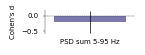

: 

: 

: 

: 

: 

: 

In [74]:
kind = 'absolute'
ycols = ['psd_sum_5to95']
band_barplot_severity(df_abs, kind, ycols)

effect_size gamma_low: -0.17
effect_size gamma_low: -0.11
effect_size gamma_low: 0.05


/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_87891/352966883.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cond[hue] = df_cond[hue].astype('category')
/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_87891/352966883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cond[hue] = df_cond[hue].cat.rename_categories(rename)
/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_87891/352966883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

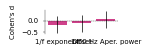

: 

: 

: 

: 

: 

: 

In [76]:
kind = 'periodicAP'
ycols = ['fm_exponent', 'fm_offset_log', 'full_fm_band_aperiodic_log']
band_barplot_severity(df_per, kind, ycols)

: 

: 

: 

: 

: 

: 